### Load python packages

In [ ]:
import numpy as np    # matrices and high-level math functions
import pandas as pd   # data manipulation
import datetime       # working with dates 

# For data visualization
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# For ML part
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import IterativeImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Set random seed so that the notebook's output is identical for every run
STATE = 2022
np.random.seed(2022)

### Import dataset

### About the dataset

**Context:**
You are provided with historical sales data for 45 stores located in different regions - each store contains a number of departments. The company also runs several promotional markdown events throughout the year. These markdowns precede prominent holidays, the four largest of which are the Super Bowl, Labor Day, Thanksgiving, and Christmas. The weeks including these holidays are weighted five times higher in the evaluation than non-holiday weeks.

**Data files:**
1. 'stores.csv': Anonymized information about the 45 stores, indicating the type and size of store
2. 'features.csv': Contains additional data related to the store, department, and regional activity for the given dates.
3. 'sales.csv': Historical sales data, which covers to 2010-02-05 to 2012-11-01.

*Credits:* https://www.kaggle.com/manjeetsingh/retaildataset

In [ ]:
PATH = 'https://raw.githubusercontent.com/bhevencious/datasets/main/'

sales_df = pd.read_csv(PATH+'sales.csv')
stores_df = pd.read_csv(PATH+'stores.csv')
features_df = pd.read_csv(PATH+'features.csv')

# Convert object types to datetime
features_df['Date'] = pd.to_datetime(features_df['Date'])
sales_df['Date'] = pd.to_datetime(sales_df['Date'])

# Merge datasets
features_df = features_df.merge(stores_df, on='Store')
df = features_df.merge(sales_df, on=['Store','Date','IsHoliday'])

In [ ]:
#features_df = pd.read_csv(features, header=0)

In [ ]:
df.head()

Store       Date  Temperature  Fuel_Price  ...  Type    Size  Dept  Weekly_Sales
0      1 2010-05-02        42.31       2.572  ...     A  151315     1      24924.50
1      1 2010-05-02        42.31       2.572  ...     A  151315     2      50605.27
2      1 2010-05-02        42.31       2.572  ...     A  151315     3      13740.12
3      1 2010-05-02        42.31       2.572  ...     A  151315     4      39954.04
4      1 2010-05-02        42.31       2.572  ...     A  151315     5      32229.38

[5 rows x 16 columns]

### Exploratory data analysis and data visualization

In [ ]:
df.info()
df.describe().T

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Date          421570 non-null  datetime64[ns]
 2   Temperature   421570 non-null  float64       
 3   Fuel_Price    421570 non-null  float64       
 4   MarkDown1     150681 non-null  float64       
 5   MarkDown2     111248 non-null  float64       
 6   MarkDown3     137091 non-null  float64       
 7   MarkDown4     134967 non-null  float64       
 8   MarkDown5     151432 non-null  float64       
 9   CPI           421570 non-null  float64       
 10  Unemployment  421570 non-null  float64       
 11  IsHoliday     421570 non-null  bool          
 12  Type          421570 non-null  object        
 13  Size          421570 non-null  int64         
 14  Dept          421570 non-null  int64         
 15  Weekly_Sales  421

count           mean  ...            75%            max
Store         421570.0      22.200546  ...      33.000000      45.000000
Temperature   421570.0      60.090059  ...      74.280000     100.140000
Fuel_Price    421570.0       3.361027  ...       3.738000       4.468000
MarkDown1     150681.0    7246.420196  ...    9210.900000   88646.760000
MarkDown2     111248.0    3334.628621  ...    1926.940000  104519.540000
MarkDown3     137091.0    1439.421384  ...     103.990000  141630.610000
MarkDown4     134967.0    3383.168256  ...    3595.040000   67474.850000
MarkDown5     151432.0    4628.975079  ...    5563.800000  108519.280000
CPI           421570.0     171.201947  ...     212.416993     227.232807
Unemployment  421570.0       7.960289  ...       8.572000      14.313000
Size          421570.0  136727.915739  ...  202505.000000  219622.000000
Dept          421570.0      44.260317  ...      74.000000      99.000000
Weekly_Sales  421570.0   15981.258123  ...   20205.852500  693099.360000

[13 rows x 8 columns]

### Check for duplicates

In [ ]:
# Check for duplicates
print('Duplicates:',df.duplicated().sum())

Duplicates: 0


### Plot a trend of selected variables (Temperature, Fuel price, CPI, unemployment)

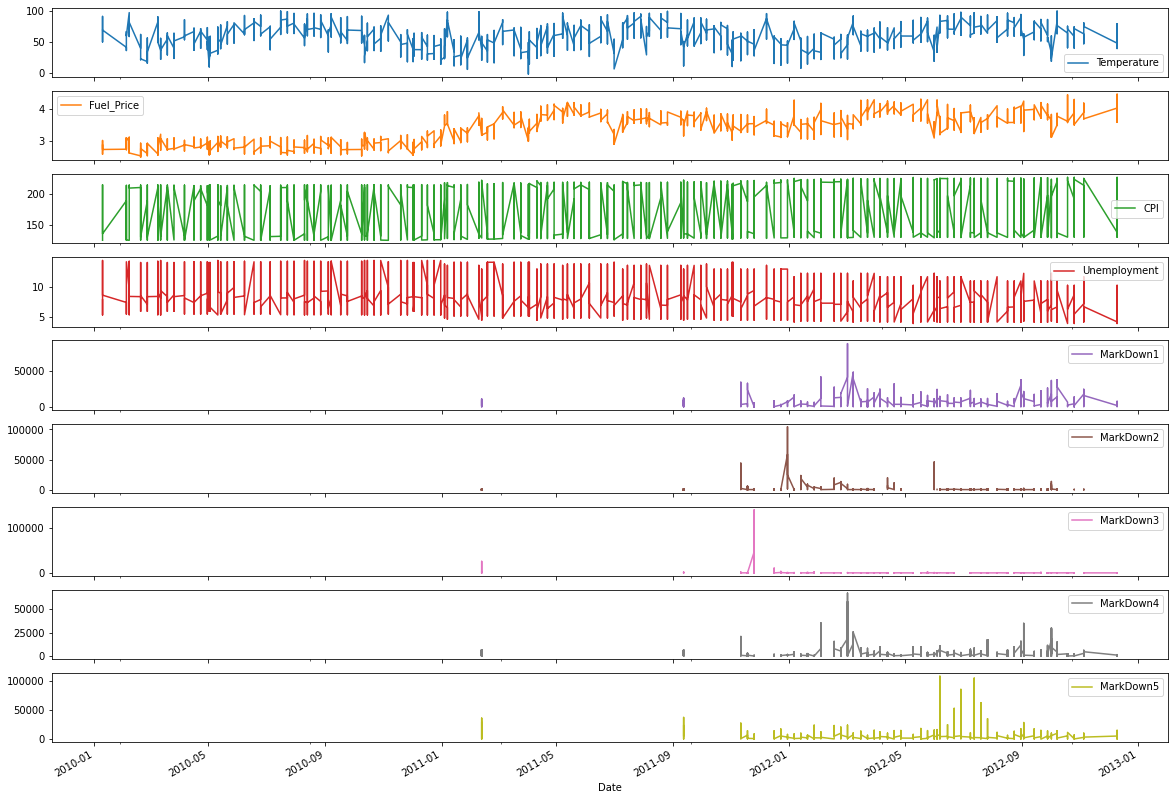

In [ ]:
df[['Date', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 
    'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']].plot(x='Date', subplots=True, figsize=(20,15))
plt.show()

### Plot distribution of variables

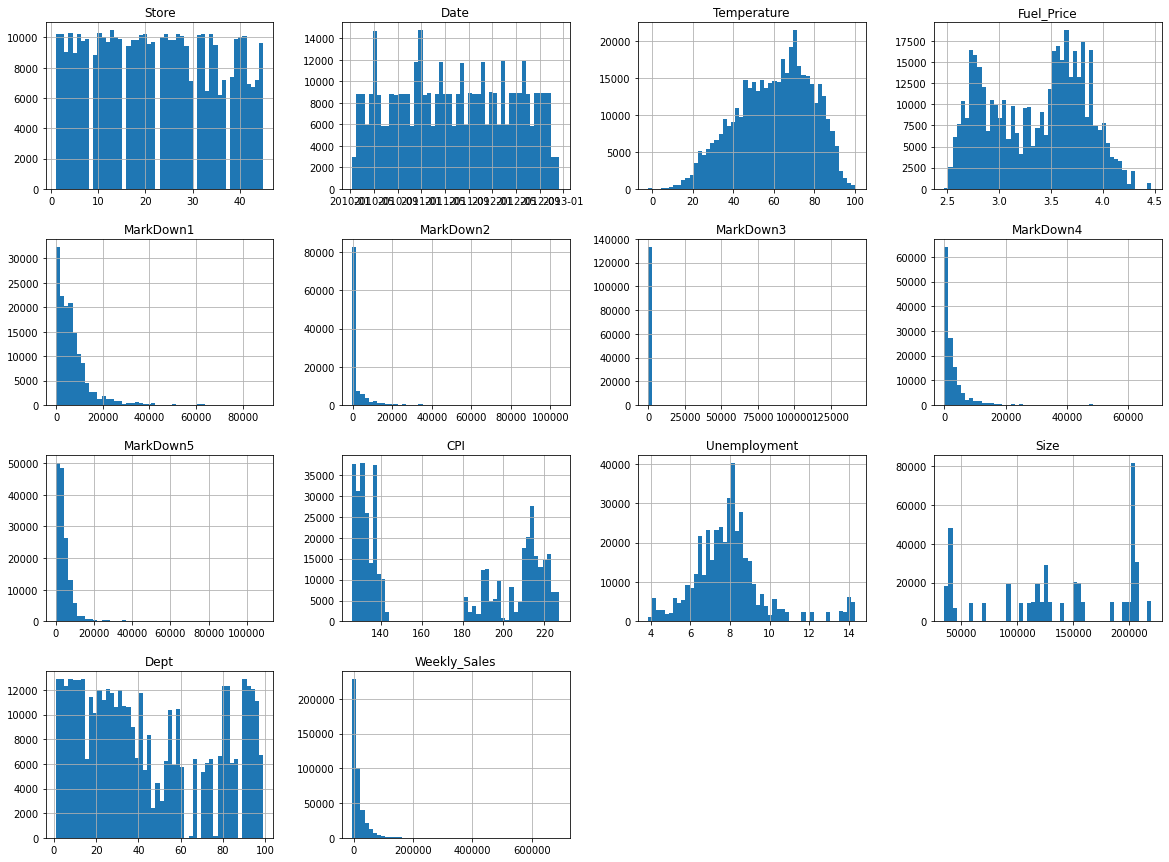

In [ ]:
df.hist(bins=50, figsize=(20,15))
plt.show()

In [ ]:
# Sum the weekly sales from every store to get the total weekly sales volume of the retail chain
df_total_weekly_sales = df.groupby(by=['Date'], as_index=False)['Weekly_Sales'].sum()
df_weekly_sales = df_total_weekly_sales.sort_values('Weekly_Sales', ascending=False)

fig = px.line(df_total_weekly_sales, x='Date', y='Weekly_Sales', title='Total weekly sales volume', width=1200, height=800, template='plotly', 
              labels={
                  'x':'Date', 'Weekly_Sales':'Weekly sales volume'
              }
            )
fig.show()

In [ ]:
# Top 5 remunerative weeks
df_weekly_sales.head()

Date  Weekly_Sales
46 2010-12-24   80931415.60
98 2011-12-23   76998241.31
95 2011-11-25   66593605.26
41 2010-11-26   65821003.24
45 2010-12-17   61820799.85

In [ ]:
# Bottom 5 remunerative weeks
df_weekly_sales[::-1].head()

Date  Weekly_Sales
52  2011-01-28   39599852.99
103 2012-01-27   39834974.67
47  2010-12-31   40432519.00
51  2011-01-21   40654648.03
50  2011-01-14   40673678.04

In [ ]:
# Top performing store type in term of sales
df_top_stores = df.groupby(by=['Type'], as_index=False)['Weekly_Sales'].sum()
df_top_stores.sort_values('Weekly_Sales', ascending=False)

Type  Weekly_Sales
0    A  4.331015e+09
1    B  2.000701e+09
2    C  4.055035e+08

### Plot correlation of variables

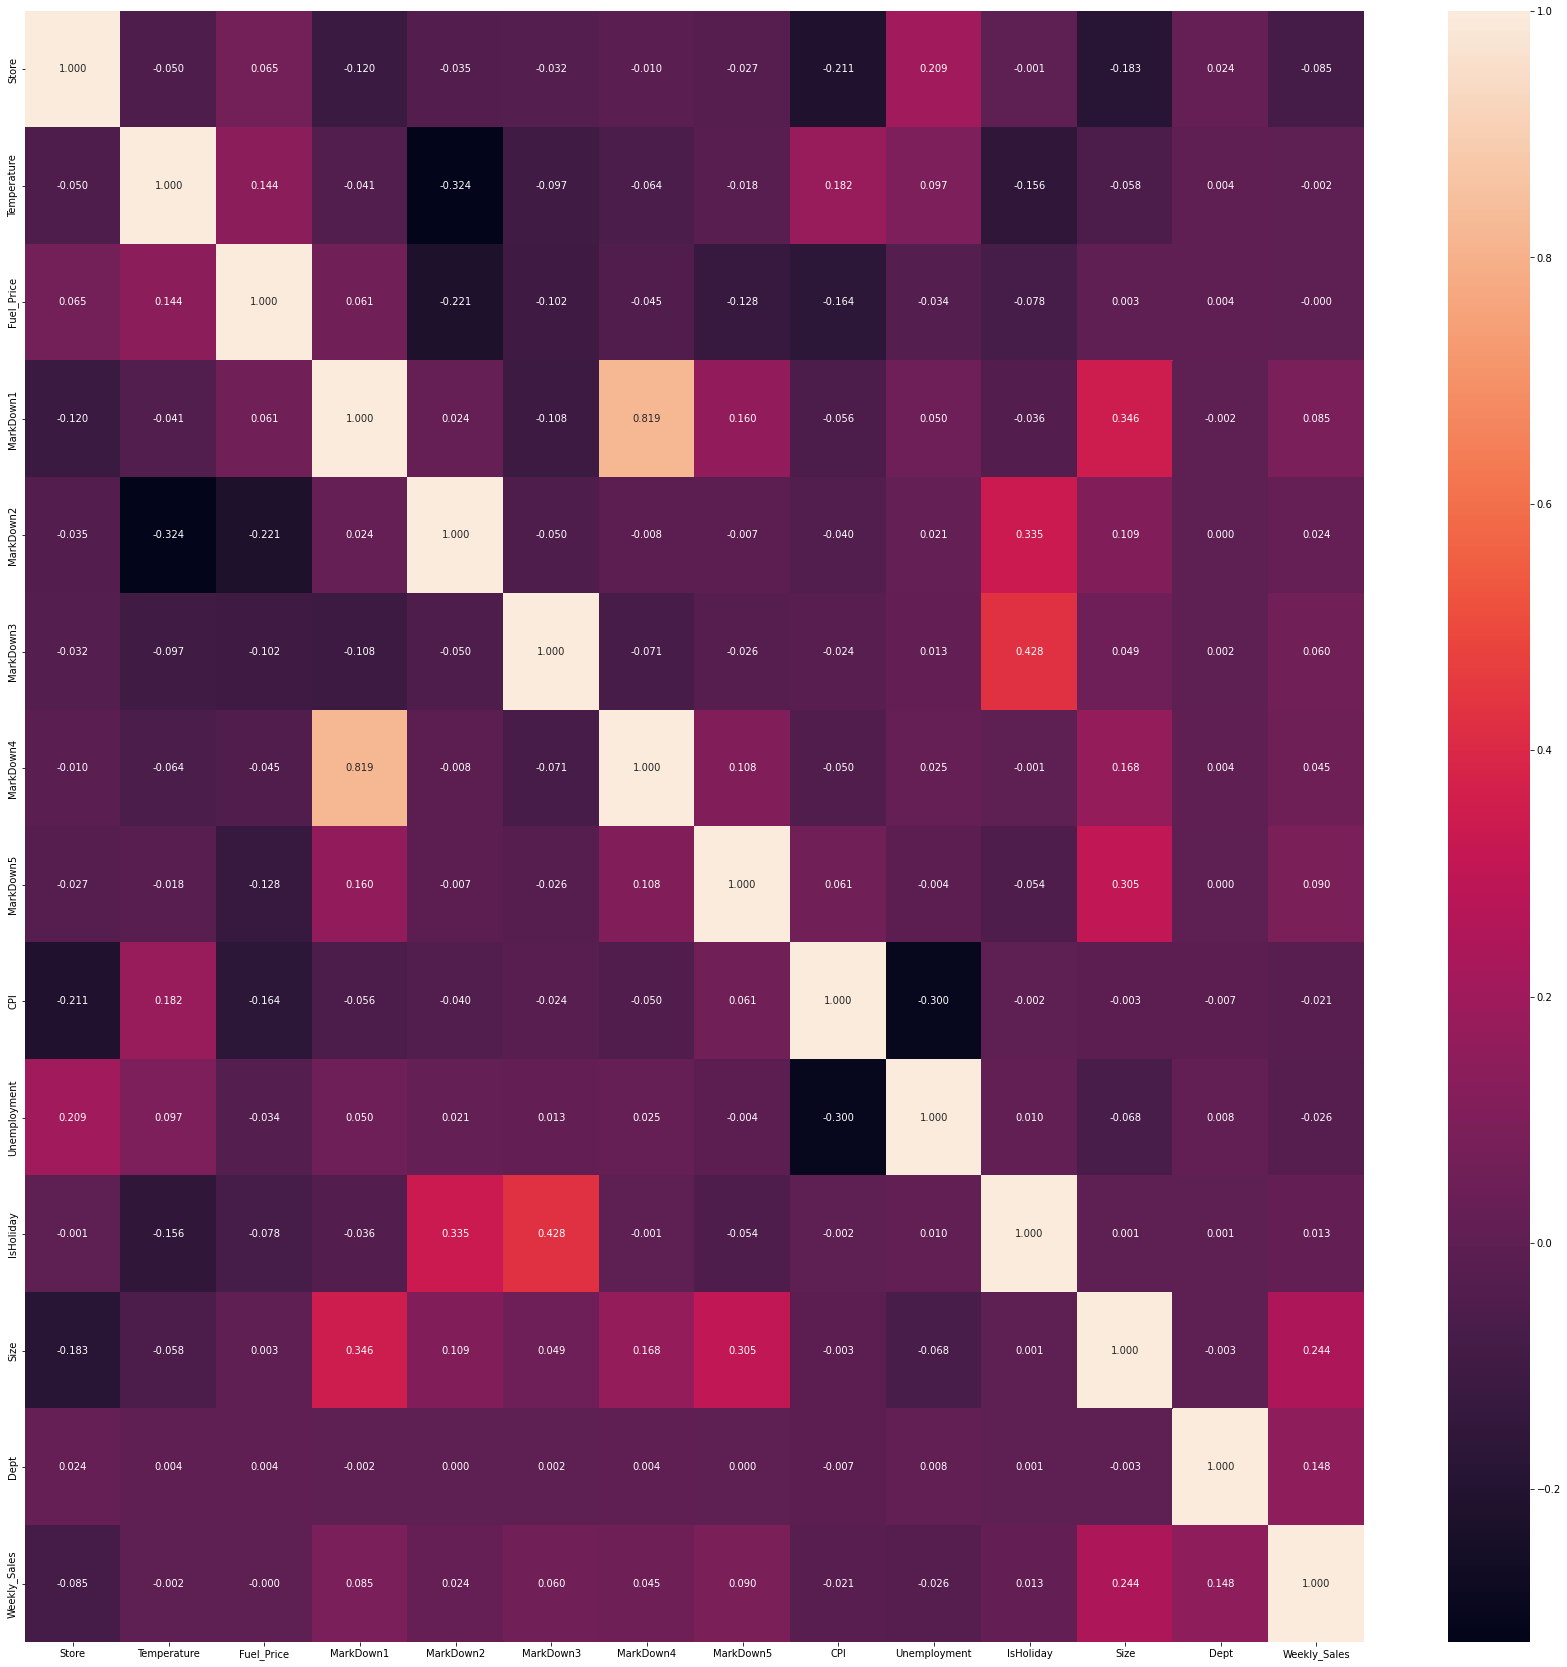

In [ ]:
# Correlation matrix
corr = df.corr()
plt.figure(figsize=(30,30))
sns.heatmap(corr, 
            annot=True, fmt=".3f",
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

In [ ]:
corr.loc['Weekly_Sales'].abs().sort_values(ascending=False)

Weekly_Sales    1.000000
Size            0.243828
Dept            0.148032
MarkDown5       0.090362
MarkDown1       0.085251
Store           0.085195
MarkDown3       0.060385
MarkDown4       0.045414
Unemployment    0.025864
MarkDown2       0.024130
CPI             0.020921
IsHoliday       0.012774
Temperature     0.002312
Fuel_Price      0.000120
Name: Weekly_Sales, dtype: float64

### Question 1 (1 pt)
Which feature has the highest correlation with "Weekly_Sales" except itself? 

$\color{blue}{\textit Answer:}$  
"Size" has the highest correlation with "Weekly_Sales".

Choose the top 4 most correlated features with "Weekly_Sales". Fill in the following attributes to visualize their scatter plots.

$\color{blue}{\textit Answer:}$  
The top 4 most correlated features with "Weekly_Sales" listed in order of most correlated to least correlated are:
1. "Size"
2. "Dept"
3. "MarkDown5"
4. "MarkDown1"


In [ ]:
attributes = ['Size', 'Dept', 'MarkDown5', 'MarkDown1'] #TODO:Fill this in.
fig = px.scatter_matrix(df[attributes], width=1200, height=800)
fig.show()

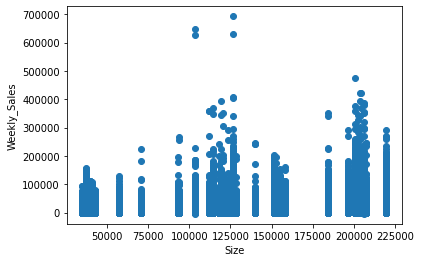

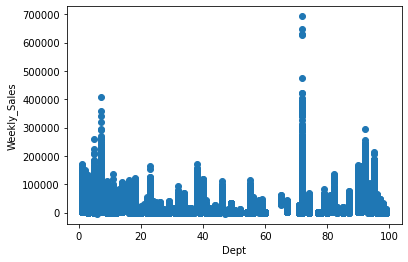

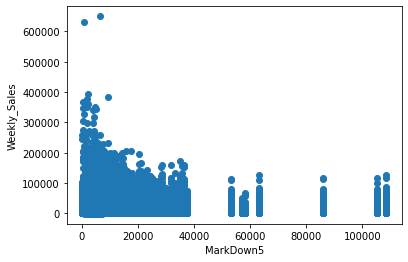

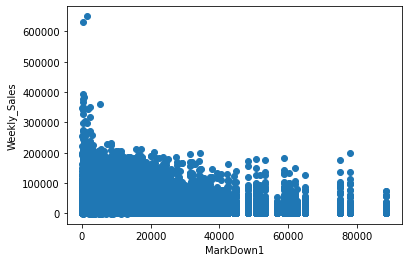

In [ ]:
for feat in attributes:
  #plt.figure(figsize=(10,10))
  plt.scatter(df[feat], df['Weekly_Sales'])
  plt.xlabel(feat)
  plt.ylabel('Weekly_Sales')

  plt.show()

### Data preparation for ML models

In [ ]:
one_hot_encoding = pd.get_dummies(df['Type'])
df = df.join(one_hot_encoding)
df = df.drop(columns=['Type'])
df.head()

Store       Date  Temperature  Fuel_Price  ...  Weekly_Sales  A  B  C
0      1 2010-05-02        42.31       2.572  ...      24924.50  1  0  0
1      1 2010-05-02        42.31       2.572  ...      50605.27  1  0  0
2      1 2010-05-02        42.31       2.572  ...      13740.12  1  0  0
3      1 2010-05-02        42.31       2.572  ...      39954.04  1  0  0
4      1 2010-05-02        42.31       2.572  ...      32229.38  1  0  0

[5 rows x 18 columns]

In order to interpolate NaN values, the dataframe must be indexed by Date

In [ ]:
df = df.set_index(['Date', 'Store', 'Dept']).sort_index()

In [ ]:
df['CPI'] = df['CPI'].interpolate(method='linear')
df['Unemployment'] = df['Unemployment'].interpolate(method='linear')

In [ ]:
# Check for null values
df.isna().sum()

Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
IsHoliday            0
Size                 0
Weekly_Sales         0
A                    0
B                    0
C                    0
dtype: int64

In [ ]:
df['MarkDown1'] = IterativeImputer(random_state=0).fit_transform(df['MarkDown1'].values.reshape(-1, 1))
df['MarkDown2'] = IterativeImputer(random_state=0).fit_transform(df['MarkDown2'].values.reshape(-1, 1))
df['MarkDown3'] = IterativeImputer(random_state=0).fit_transform(df['MarkDown3'].values.reshape(-1, 1))
df['MarkDown4'] = IterativeImputer(random_state=0).fit_transform(df['MarkDown4'].values.reshape(-1, 1))
df['MarkDown5'] = IterativeImputer(random_state=0).fit_transform(df['MarkDown5'].values.reshape(-1, 1))

In [ ]:
df = df.reset_index()

In [ ]:
df = df[df['Dept'].notna()]

In [ ]:
# Date should be decomposed into Year and a cyclical feature for Day of Year
df['Year'] = df['Date'].dt.year
df['DayOfYear'] = df['Date'].dt.day
df['DayOfYearCos'] = np.cos(df['DayOfYear'])
df['DayOfYearSin'] = np.sin(df['DayOfYear'])

In [ ]:
df.head()

Date  Store  Dept  ...  DayOfYear  DayOfYearCos  DayOfYearSin
0 2010-01-10      1     1  ...         10     -0.839072     -0.544021
1 2010-01-10      1     2  ...         10     -0.839072     -0.544021
2 2010-01-10      1     3  ...         10     -0.839072     -0.544021
3 2010-01-10      1     4  ...         10     -0.839072     -0.544021
4 2010-01-10      1     5  ...         10     -0.839072     -0.544021

[5 rows x 22 columns]

In [ ]:
# Normalizing values between 0 and 1
df['Store'] = MinMaxScaler().fit_transform(df['Store'].values.reshape((-1, 1)))
df['Temperature'] = MinMaxScaler().fit_transform(df['Temperature'].values.reshape((-1, 1)))
df['Fuel_Price'] = MinMaxScaler().fit_transform(df['Fuel_Price'].values.reshape((-1, 1)))
df['MarkDown1'] = MinMaxScaler().fit_transform(df['MarkDown1'].values.reshape((-1, 1)))
df['MarkDown2'] = MinMaxScaler().fit_transform(df['MarkDown2'].values.reshape((-1, 1)))
df['MarkDown3'] = MinMaxScaler().fit_transform(df['MarkDown3'].values.reshape((-1, 1)))
df['MarkDown4'] = MinMaxScaler().fit_transform(df['MarkDown4'].values.reshape((-1, 1)))
df['MarkDown5'] = MinMaxScaler().fit_transform(df['MarkDown5'].values.reshape((-1, 1)))
df['CPI'] = MinMaxScaler().fit_transform(df['CPI'].values.reshape((-1, 1)))
df['Unemployment'] = MinMaxScaler().fit_transform(df['Unemployment'].values.reshape((-1, 1)))
df['IsHoliday'] = df['IsHoliday'].astype(int)
df['Dept'] = MinMaxScaler().fit_transform(df['Dept'].values.reshape((-1, 1)))
df['Weekly_Sales'] = MinMaxScaler().fit_transform(df['Weekly_Sales'].values.reshape((-1, 1)))
df['Size'] = MinMaxScaler().fit_transform(df['Size'].values.reshape((-1, 1)))

In [ ]:
df = df.set_index('Date')

In [ ]:
X = df.drop(columns=['Weekly_Sales', 'Year', 'DayOfYear']).values
y = df['Weekly_Sales'].values

In [ ]:
# Split training set into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=STATE)

In [ ]:
dtr_regressor = DecisionTreeRegressor(max_depth=50, min_samples_leaf=200, random_state=STATE)
dtr_regressor = dtr_regressor.fit(X_train, y_train)
y_pred = dtr_regressor.predict(X_test)
r2_test = dtr_regressor.score(X_test, y_test)
print('R2 Score for test set:', r2_test)

R2 Score for test set: 0.8608393788432436


### Question 2 (4 pts) 
Use grid search with 5-fold cross-validation (with help of 'Grid Search CV' class) to find good hyperparameter values for a DecisionTreeRegressor. 
*(Hint: try various values for 'max_depth', 'min_samples_leaf', 'max_leaf_nodes' in the range 0-200)*

Measure your model's performance on the test set. 

In [ ]:
dtree = DecisionTreeRegressor()

dtree_gs_params = {'max_depth':list(range(150, 200, 25)), 'min_samples_leaf':list(range(40,80,10)), 
          'max_leaf_nodes':list(range(150,200,10))}

dtree_gsearch = GridSearchCV(dtree, param_grid=dtree_gs_params)
dtree_gsearch.fit(X_train, y_train)

In [ ]:
dtree_gsearch.best_params_

{'max_depth': 150, 'max_leaf_nodes': 190, 'min_samples_leaf': 50}

In [ ]:
best_dtree = DecisionTreeRegressor(max_depth=150, max_leaf_nodes=190, min_samples_leaf=50)
best_dtree.fit(X_train, y_train)
best_dtree.score(X_test, y_test)

### Question 3 (8 pts)
Try different boosting regressors from 'sklearn.ensemble' (RandomForest, AdaBoost) with Grid Search CV and report their testing and prediction accuracies

Answer:
I was only able to try a RandomizedSearch for RandomForest because the runtime on colab kept disconnecting.
The plan was to do a randomizedsearch first, then a gridsearch for RandomForest and GradientBoosting.
I have a single result from the best parameters of RandomForestRegressor, 
test score = 0.934.

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, StackingRegressor
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
### RANDOM FOREST REGRESSOR
# RandomSearch first and then narrow down the parameter option using GridSearch

In [ ]:
# RandomSearch

rf_n_estimators = list(range(100, 200, 50))
rf_max_depth = list(range(50, 100, 20))
rf_min_samples_leaf = list(range(20,100, 20))


rf_random_params = {'n_estimators': rf_n_estimators,
                    'max_depth': rf_max_depth,
                    'min_samples_leaf': rf_min_samples_leaf}

rf = RandomForestRegressor()

rf_random = RandomizedSearchCV(rf, rf_random_params, verbose=0,
                               n_jobs=-1, random_state=26)

rf_random.fit(X_train, y_train)

RandomizedSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [50, 70, 90],
                                        'min_samples_leaf': [20, 40, 60, 80],
                                        'n_estimators': [100, 150]},
                   random_state=26)

In [ ]:
rf_random.best_estimator_

RandomForestRegressor(max_depth=70, min_samples_leaf=20, n_estimators=150)

In [ ]:
# RandomSearch RandomForest best estimator score on test set

best_rf = rf_random.best_estimator_
best_rf.fit(X_train, y_train)
best_rf.score(X_test, y_test)

0.934621979203747

In [ ]:
# GridSearch to fine-tune parameter values obtained from the RandomSearch

rf_n_estimators = list(range(140, 160, 10))
rf_max_depth = list(range(60, 85, 10))
rf_min_samples_leaf = list(range(10,40, 10))


rf_random_params = {'n_estimators': rf_n_estimators,
                    'max_depth': rf_max_depth,
                    'min_samples_leaf': rf_min_samples_leaf}

rf = RandomForestRegressor()

rf_random_gsearch = GridSearchCV(rf, rf_random_params, verbose=3,
                               n_jobs=-1)

rf_random_gsearch.fit(X_train, y_train)

rf_random_gsearch.best_estimator_

In [ ]:
## GRADIENT-BOOST-REGRESSOR

In [ ]:

gboost = GradientBoostingRegressor(random_state = 26)
gboost_params = {'n_estimators':[100, 200, 500, 1000] }

gboost_gsearch = GridSearchCV(estimator=adab, param_grid=adab_params, cv=5, n_jobs=-1, verbose=3)
gboost_gsearch.fit(X_train, y_train)
gboost_gsearch.best_estimator_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


KeyboardInterrupt: ignored

In [ ]:
# Gradient boost regressor

best_gboost = gboost_gsearch.best_estimator_
best_gboost.fit(X_train, y_train)
best_gboost.score(X_test, y_test)

AdaBoostRegressor(n_estimators=10, random_state=26)

### Question 4 (7 pts)
Ensemble (stack) the regressors from the above and report the R2 score on test set.


In [ ]:
# StackingRegressor

estimators = [('dt', DecisionTreeRegressor()), ('gboost', GradientBoostRegressor()),
('rf', RandomForestRegressor())]

final_reg = StackingRegressor(estimators=estimators)

final_reg.fit(X_train, y_pred)
final_reg.score(X_test, y_test)